# Make LBA values to test EveryBeam LOFAR against

First up, make a convenience function around the existing EveryBeam python wrapper.

In [1]:
import everybeam as eb
import numpy as np
import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, ITRS

def radec_to_xyz(ra : float, dec : float, time : Time):
    """
    Convert RA and Dec ICRS coordinates to ITRS cartesian coordinates.
    
    Taken from the everybeam documentation
    https://everybeam.readthedocs.io/en/latest/tree/demos/lofar-array-factor.html

    Args:
        ra (astropy.coordinates.Angle): Right ascension
        dec (astropy.coordinates.Angle): Declination
        time float astropy time instance

    Returns:
        pointing_xyz (ndarray): NumPy array containing the ITRS X, Y and Z coordinates
    """
    
    coord = SkyCoord(ra*u.rad, dec*u.rad, frame='icrs')
    coord_itrs = coord.transform_to(ITRS(obstime=time))
    
    return np.asarray(coord_itrs.cartesian.xyz.transpose())

def run_everybeam_lofar(ras: np.ndarray, decs: np.ndarray,
                        beam_ra0: float, beam_dec0: float,
                        j2000_latitudes: np.ndarray, j2000_lsts: np.ndarray,
                        times: np.ndarray, freqs: np.ndarray,
                        telescope: eb.Telescope, # type: ignore
                        station_ids: np.ndarray,
                        apply_beam_norms: bool = False,
                        reorder_jones: bool = False,
                        element_only: bool = False,
                        eb_rotate: bool = False) -> np.ndarray:
    """
    Calculate the Jones matrices for a given set of coordinates, times,
    frequencies, and station ids using the EveryBeam library.
    `j2000_latitudes` should be the array latitude as precessed back to J2000,
    with `j2000_lsts` being the matching LST in J2000.
    `telescope` should be an EveryBeam telescope object.
    
    Parameters
    ------------
    ras : np.ndarray
        Right ascensions of the coordinates in radians.
    decs : np.ndarray
         Declinations of the coordinates in radians.
    beam_ra0 : float
        Right ascension of the beam center in radians.
    beam_dec0 : float
        Declination of the beam center in radians.
    j2000_latitudes : np.ndarray
        Latitudes in J2000 coordinates.
    j2000_lsts : np.ndarray
        Local sidereal times in J2000 coordinates.
    times : np.ndarray
        Array of observation times.
    freqs : np.ndarray
        Array of frequencies.
    telescope : (eb.Telescope):
        Telescope object from the EveryBeam library.
    station_ids : np.ndarray
        Array of station IDs.
    apply_beam_norms : bool, optional
        Whether to apply beam normalisation. Defaults to False. Achieved by
        calculating the beam response at beam centre, and multiplying all
        Jones by the inverse of this central beam response.
    reorder_jones : bool, optional
        Whether to reorder the Jones matrices. Defaults to False. Just rearranges
        the Jones matrix from [[0,0, 0,1,], [1,0, 1,1]] to [[1,1, 1,0,], [0,1, 0,0]].
    element_only : bool, optional
        Whether to use only the element response. Defaults to False. Use this to
        look at the dipole response only, not the beam formed response.
    eb_rotate : bool, optional
        Whether to apply parallactic rotation using EveryBeam. Defaults to False.
        Should probably be used for everything apart from MWA beams.
        
    Returns
    --------
    np.ndarray
        The calculated Jones matrices with shape (num_stations, num_times, num_freqs, num_coords, 2, 2).
    """
    
    # print("YO MR WHITE", type(telescope))
    
    num_stations = len(station_ids)
    num_times = len(times)
    num_freqs = len(freqs)
    num_coords = len(ras)
    
    all_output_jones = np.zeros((num_stations, num_times, num_freqs, num_coords, 2, 2), dtype=np.complex128)*np.nan
    
    for time_ind, time in enumerate(times):
        phase_itrf = radec_to_xyz(beam_ra0, beam_dec0, time)
        dir_itrfs = radec_to_xyz(ras, decs, time)
                
        time_mjd_secs = time.mjd*3600*24
        
        for station_ind, station_id in enumerate(station_ids):
            for freq_ind, freq in enumerate(freqs):
                if apply_beam_norms:
                    element_id = 0
                    if element_only:
                        norm_jones = telescope.element_response(time_mjd_secs, station_id, element_id, freq,
                                                            phase_itrf, rotate=eb_rotate)
                    else:
                        norm_jones = telescope.station_response(time_mjd_secs, station_id, freq,
                                                                phase_itrf, phase_itrf, 
                                                                rotate=eb_rotate)
                        
                for coord_ind, (ra, dec) in enumerate(zip(ras, decs)):
                    if element_only:
                        response = telescope.element_response(time_mjd_secs, station_id, freq,
                                                            dir_itrfs[coord_ind], rotate=eb_rotate)
                    else:
                        response = telescope.station_response(time_mjd_secs, station_id, freq,
                                                              dir_itrfs[coord_ind], phase_itrf, 
                                                              rotate=eb_rotate)
                        all_output_jones[station_ind, time_ind, freq_ind, coord_ind] = response
                                
                if apply_beam_norms:
                    ##Each station, time, and freq gets it's own normalisation
                    ##Same 2x2 normalisation for all directions
                    inv_beam_norms = np.linalg.inv(norm_jones)
                    output_jones = np.einsum('lm,kmn->kln', inv_beam_norms, all_output_jones[station_ind, time_ind, freq_ind, :, :, :])
                    all_output_jones[station_ind, time_ind, freq_ind, :, :, :] = output_jones
                    
    if reorder_jones:
        ##swap all_output_jones[:,:,:,:,0,0] with all_output_jones[:,:,:,:,1,1]
        all_output_jones[:, :, :, :, [0, 1], [0, 1]] = all_output_jones[:, :, :, :, [1, 0], [1, 0]]
        ##swap all_output_jones[:,:,:,:,0,1] with all_output_jones[:,:,:,:,1,0]
        all_output_jones[:, :, :, :, [0, 1], [1, 0]] = all_output_jones[:, :, :, :, [1, 0], [0, 1]]
                    
    return all_output_jones

In [2]:
import numpy as np
from casacore.tables import table

ms_path="../../../test_installation/everybeam/lba.MS"

with table(ms_path + "::FIELD") as field_subtable:
    print(field_subtable.colnames())
    delay_dir = field_subtable.getcol('DELAY_DIR')
    print(f"This file is phased to RA, Dec {np.degrees(np.squeeze(delay_dir))}?" )
    phase_dir = field_subtable.getcol('PHASE_DIR')
    print(f"This file is phased to RA, Dec {np.degrees(np.squeeze(phase_dir))}?" )
    
    
RA0 = np.squeeze(phase_dir)[0] + 2*np.pi
DEC0 = np.squeeze(phase_dir)[1]

print(f"RA0, DEC0 = {np.degrees(RA0)}, {np.degrees(DEC0)}")
    

Successful readonly open of default-locked table ../../../test_installation/everybeam/lba.MS::FIELD: 10 columns, 1 rows
['DELAY_DIR', 'PHASE_DIR', 'REFERENCE_DIR', 'CODE', 'FLAG_ROW', 'NAME', 'NUM_POLY', 'SOURCE_ID', 'TIME', 'LOFAR_TILE_BEAM_DIR']
This file is phased to RA, Dec [-82.6175796  48.7461556]?
This file is phased to RA, Dec [-82.6175796  48.7461556]?
RA0, DEC0 = 277.3824204, 48.7461556


This isn't necessarily where the _beam_ is pointed though, we have to dig a little deeper to find that out.

In [3]:
lofar_pointings = table(ms_path + "::FIELD")

# delay_dir = lofar_pointings.getcol('DELAY_DIR')
delay_dir = lofar_pointings.getcol('DELAY_DIR')

print(delay_dir.shape)

print(np.squeeze(np.degrees(delay_dir)))

lofar_tile_beam_dir =  np.squeeze(lofar_pointings.getcol('LOFAR_TILE_BEAM_DIR'))
print(np.degrees(lofar_tile_beam_dir))

reference_dir =  np.squeeze(lofar_pointings.getcol('REFERENCE_DIR'))
print(np.degrees(reference_dir))

Successful readonly open of default-locked table ../../../test_installation/everybeam/lba.MS::FIELD: 10 columns, 1 rows
(1, 1, 2)
[-82.6175796  48.7461556]
[-82.6175796  48.7461556]
[-82.6175796  48.7461556]


In [4]:
from astropy.coordinates import EarthLocation
from astropy.time import Time, TimeDelta
from astropy import units as u
LATITUDE_LOFAR=52.905329712
LONGITUDE_LOFAR=6.867996528

with table(ms_path) as ms:
    time_col = ms.getcol("TIME")
    mjd_secs = time_col[0]
    
date = Time(mjd_secs*u.s, format='mjd')
first_date = date.datetime.strftime('%Y-%m-%dT%H:%M:%S')
print(first_date, date.mjd*24*3600)
observing_location = EarthLocation(lat=LATITUDE_LOFAR*u.deg,
                                   lon=LONGITUDE_LOFAR*u.deg, height=0)


time_inc = 3*3600

times = [Time(date, scale='utc', location=observing_location) + TimeDelta(time_inc*i, format='sec') for i in range(2)]

lsts = [time.sidereal_time('mean').rad for time in times]

print(np.degrees(lsts))
    

Successful readonly open of default-locked table ../../../test_installation/everybeam/lba.MS: 24 columns, 4218 rows
2014-11-04T15:58:05 4921833485.00695
[290.20517129 335.32837635]


In [5]:
from astropy.io import fits
from astropy.wcs import WCS

##Setup a dummy FITS header with appropriate settings
header = fits.Header()

##Give it 301 pixel for each axis
nside = 31

##This resolution seems to cover the full sky nicely
cpix = int(nside // 2) + 1
cdelt = 0.35
cdelt = 40 / nside

header['NAXIS']   = 2
header['NAXIS1']  = nside
header['NAXIS2']  = nside
header['CTYPE1']  = 'RA---SIN'
header['CRPIX1']  = cpix
header['CRVAL1']  = np.degrees(RA0)
header['CDELT1']  = cdelt
header['CUNIT1']  = 'deg     '
header['CTYPE2']  = 'DEC--SIN'
header['CRPIX2']  = cpix
header['CRVAL2']  = np.degrees(DEC0)
header['CDELT2']  = cdelt
header['CUNIT2']  = 'deg     '

##Make a world coord system
wcs = WCS(header)

##Set up x/y pixels that cover the whole image
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))

x_pixels = x_mesh.flatten()
y_pixels = y_mesh.flatten()

##convert to ra, dec
ras, decs = wcs.all_pix2world(x_pixels, y_pixels, 0.0)
ras = np.radians(ras)
decs = np.radians(decs)

In [6]:

freqs = np.array([50e+6, 100e+6])
station_ids = np.array([0,9])


telescope = eb.load_telescope(ms_path, use_differential_beam=False,
                              element_response_model='hamaker')

# apply_beam_norms
# reorder_jones
# element_only
# eb_rotate

##In the code proper, we precess the latitudes and LSTs to J2000
##No need to do that here as we're just comparing outputs
j2000_latitudes = np.array([LATITUDE_LOFAR] * len(times))
j2000_lsts = lsts


jones_rotated = run_everybeam_lofar(ras, decs, RA0, DEC0,
                                    j2000_latitudes, j2000_lsts,
                                    times, freqs, telescope, station_ids,
                                    apply_beam_norms=False,
                                    reorder_jones=False,
                                    element_only=False,
                                    eb_rotate=True)

2025-02-20 00:39:36	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-02-20 00:39:36	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-02-20 00:39:36	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


In [7]:
import matplotlib.pyplot as plt

def plot_jones_on_sky(jones, wcs, title=False,
                      show_plot = True):
    fig, axs = plt.subplots(2,4, figsize=(10, 4), layout='constrained', 
                            subplot_kw={'projection': wcs})
    
    all_gx = jones[ :, 0, 0]
    all_Dx = jones[ :, 0, 1]
    all_Dy = jones[ :, 1, 0]
    all_gy = jones[ :, 1, 1]
    
    all_gx.shape = (nside, nside)
    all_Dx.shape = (nside, nside)
    all_Dy.shape = (nside, nside)
    all_gy.shape = (nside, nside)
    
    pols = [all_gx, all_Dx, all_Dy, all_gy]
    
    for polind, pol in enumerate(['gx', 'Dx', 'Dy', 'gy']):
        
        col = polind % 2
        row = 2*(polind // 2)
        
        im0 = axs[col, row].imshow(np.real(pols[polind]), origin='lower')
        plt.colorbar(im0, ax=axs[col, row])
        axs[col, row].set_title(f'Real {pol}')
        
        im1 = axs[col, row+1].imshow(np.imag(pols[polind]), origin='lower')
        plt.colorbar(im1, ax=axs[col, row+1])
        axs[col, row+1].set_title(f'Imag {pol}')
        
    if title: fig.suptitle(title)

    for ax in axs.flatten():
        ax.grid()
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        

    if show_plot:
        plt.show()
    else:
        fig.savefig('beam_plot.png', bbox_inches='tight')

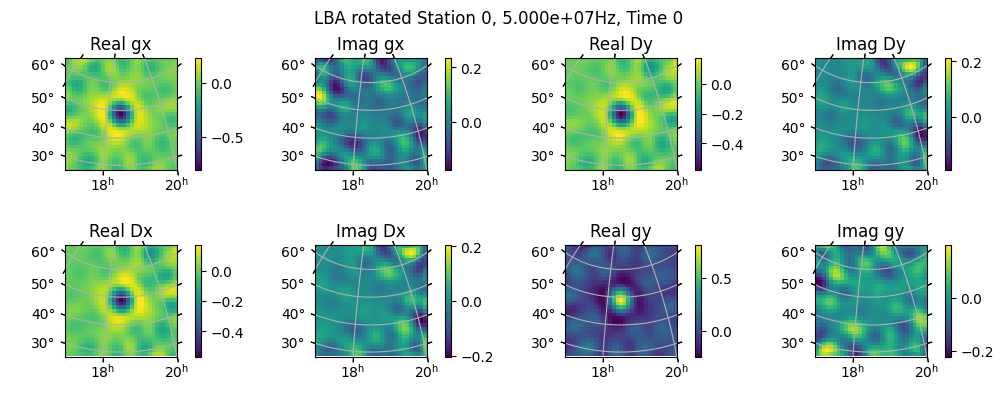

In [8]:
freq_ind = 0
station_ind = 0
time_ind = 0
plot_jones_on_sky(jones_rotated[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'LBA rotated Station {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')

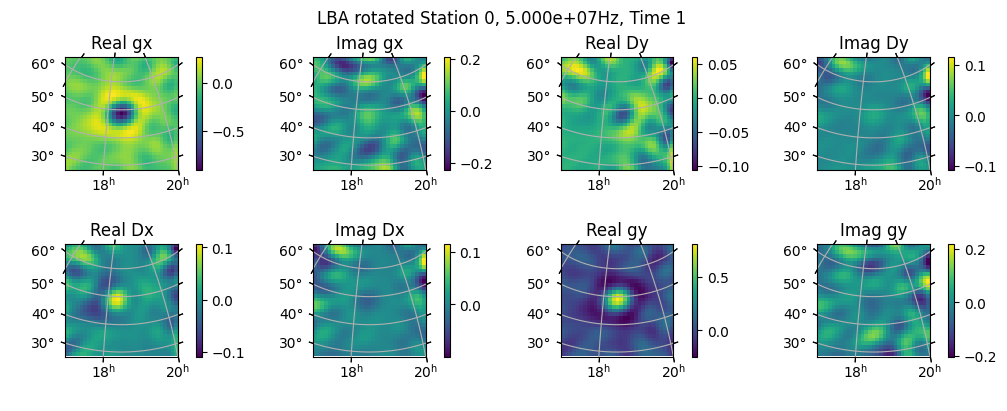

In [9]:

freq_ind = 0
station_ind = 0
time_ind = 1
plot_jones_on_sky(jones_rotated[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'LBA rotated Station {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')

In [10]:
jones_rotated_normed = run_everybeam_lofar(ras, decs, RA0, DEC0,
                                    j2000_latitudes, j2000_lsts,
                                    times, freqs, telescope, station_ids,
                                    apply_beam_norms=True,
                                    reorder_jones=False,
                                    element_only=False,
                                    eb_rotate=True)

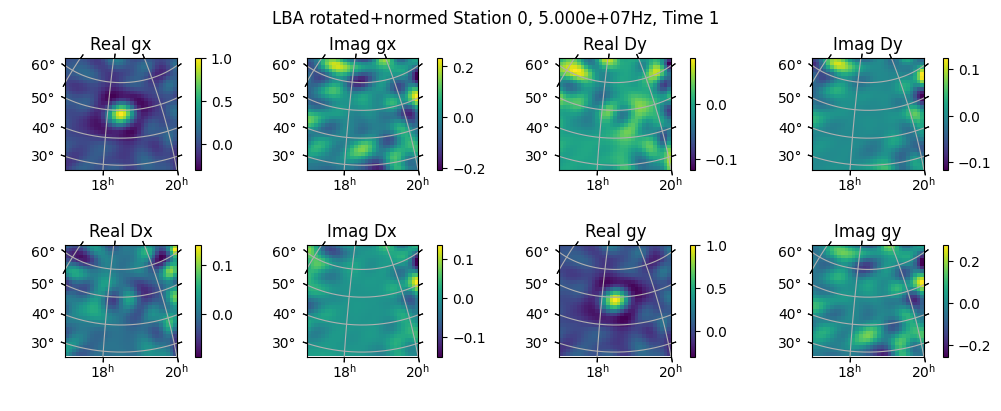

In [11]:
freq_ind = 0
station_ind = 0
time_ind = 1
plot_jones_on_sky(jones_rotated_normed[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'LBA rotated+normed Station {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')

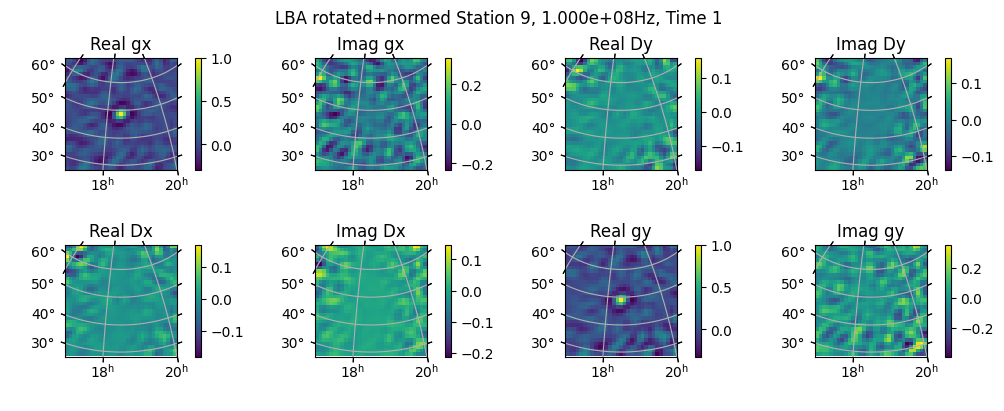

In [12]:
freq_ind = 1
station_ind = 1
time_ind = 1
plot_jones_on_sky(jones_rotated_normed[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'LBA rotated+normed Station {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')

In [13]:
jones_element_only = run_everybeam_lofar(ras, decs, RA0, DEC0,
                                    j2000_latitudes, j2000_lsts,
                                    times, freqs, telescope, station_ids,
                                    apply_beam_norms=False,
                                    reorder_jones=False,
                                    element_only=True,
                                    eb_rotate=False)

jones_reordered = run_everybeam_lofar(ras, decs, RA0, DEC0,
                                    j2000_latitudes, j2000_lsts,
                                    times, freqs, telescope, station_ids,
                                    apply_beam_norms=False,
                                    reorder_jones=True,
                                    element_only=False,
                                    eb_rotate=False)

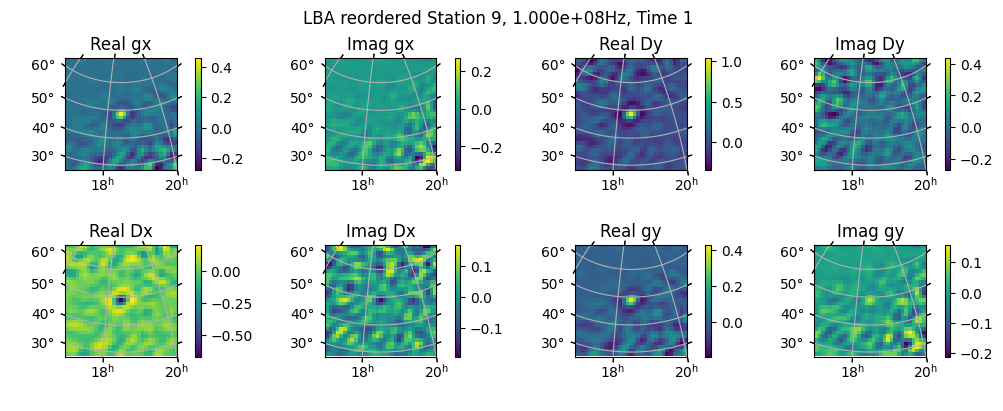

In [14]:
freq_ind = 1
station_ind = 1
time_ind = 1
plot_jones_on_sky(jones_reordered[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'LBA reordered Station {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')

In [15]:
from copy import deepcopy

def write_array(outfile, arr_name, arr):
    
    outfile.write('user_precision_t {:s}[] = {{ {:.5f}, \n'.format(arr_name, arr[0]))
                                        

    for ind in range(1,len(arr)-1):
        if ind % 10 == 0:
            outfile.write('{:.5f}, \n'.format(arr[ind]))
        else:
            outfile.write('{:.5f}, '.format(arr[ind]))
        
    outfile.write('{:.5f}}};\n'.format(arr[-1]))

    outfile.write('\n\n')

def write_jones_array(outfile, jones_name, jones):
    
    outfile.write('user_precision_t {:s}[] = {{ {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f},\n'.format(jones_name,
                                        np.real(jones[0,0,0]), np.imag(jones[0,0,0]),
                                        np.real(jones[0,0,1]), np.imag(jones[0,0,1]),
                                        np.real(jones[0,1,0]), np.imag(jones[0,1,0]),
                                        np.real(jones[0,1,1]), np.imag(jones[0,1,1])))

    for ind in range(1,jones.shape[0]-1):
        outfile.write('    {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f},\n'.format(
                                        np.real(jones[ind,0,0]), np.imag(jones[ind,0,0]),
                                        np.real(jones[ind,0,1]), np.imag(jones[ind,0,1]),
                                        np.real(jones[ind,1,0]), np.imag(jones[ind,1,0]),
                                        np.real(jones[ind,1,1]), np.imag(jones[ind,1,1])))

    outfile.write('    {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}}};\n'.format(
                                        np.real(jones[-1,0,0]), np.imag(jones[-1,0,0]),
                                        np.real(jones[-1,0,1]), np.imag(jones[-1,0,1]),
                                        np.real(jones[-1,1,0]), np.imag(jones[-1,1,0]),
                                        np.real(jones[-1,1,1]), np.imag(jones[-1,1,1])))

    outfile.write('\n\n')

jones_rotated_print = deepcopy(jones_rotated)
jones_rotated_normed_print = deepcopy(jones_rotated_normed)
jones_element_only_print = deepcopy(jones_element_only)
jones_reordered_print = deepcopy(jones_reordered)

jones_rotated_print.shape = (nside*nside*len(times)*len(freqs)*len(station_ids), 2, 2)
jones_rotated_normed_print.shape = (nside*nside*len(times)*len(freqs)*len(station_ids), 2, 2)
jones_element_only_print.shape = (nside*nside*len(times)*len(freqs)*len(station_ids), 2, 2)
jones_reordered_print.shape = (nside*nside*len(times)*len(freqs)*len(station_ids), 2, 2)

all_jones = [jones_rotated_print, jones_rotated_normed_print, jones_reordered_print]

names = ['jones_rotated', 'jones_rotated_normed', 'jones_reordered']

with open('test_run_lba_beam.h', 'w') as outfile:

    
    outfile.write('#include <math.h>\n')
    outfile.write('#include "woden_precision_defs.h"\n\n')
    
    write_array(outfile, 'ras', ras)
    write_array(outfile, 'decs', decs)
    
    for name, jones in zip(names, all_jones):
        write_jones_array(outfile, name, jones)

In [16]:
# from wodenpy.primary_beam.use_everybeam import run_everybeam

# jones_new = run_everybeam(ms_path, "", 
#                               ras, decs, RA0, DEC0,
#                               j2000_latitudes, j2000_lsts,
#                               'meh', 'meh',
#                               times, freqs, station_ids,
#                               element_response_model='hamaker',
#                               apply_beam_norms=True,
#                               iau_order=False,
#                               element_only=False,
#                               parallactic_rotate=True)


# freq_ind = 0
# station_ind = 0
# time_ind = 0
# plot_jones_on_sky(jones_rotated_normed[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'Old {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')
# plot_jones_on_sky(jones_new[station_ind, time_ind, freq_ind, :, :, :], wcs, title=f'New {station_ids[station_ind]}, {freqs[freq_ind]:.3e}Hz, Time {time_ind}')